In [1]:
import importlib

import pandas as pd
from IPython.display import display

import warnings

import Semantic_Maningfullness

warnings.filterwarnings('ignore')

from carla.data.causal_model import CausalModel

/home/jacqueline/.local/share/virtualenvs/CARLA-7s4zdYsf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jacqueline/.local/share/virtualenvs/CARLA-7s4zdYsf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jacqueline/.local/share/virtualenvs/CARLA-7s4zdYsf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint

[INFO] Using Python-MIP package version 1.12.0 [model.py <module>]


In [2]:
import numpy as np 
import torch
import random

#SEED Setting
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

In [3]:
import pandas as pd


# generate data
scm = CausalModel("sanity-3-lin")
dataset = scm.generate_dataset(10000)

# save data
# dataset.df.to_csv('generate_dataset.csv')

display(dataset.df)

,label,x1,x2,x3
0,1.0,-3.822251,3.206103,1.394095
1,0.0,-0.125186,-0.267489,-0.065593
2,0.0,1.388819,-2.420645,0.119093
3,0.0,-0.173873,-0.715379,-1.201855
4,1.0,-0.637307,1.071684,0.379442
...,...,...,...,...
9995,0.0,0.971876,-0.067054,-1.317657
9996,0.0,1.792395,-2.272653,0.620624
9997,0.0,1.994518,-3.212899,-0.900646
9998,0.0,-2.854051,3.213437,-0.361817


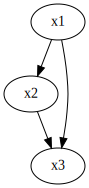

In [4]:
#Visualize the model
scm.cgm.draw()

In [5]:
from carla.models.catalog import MLModelCatalog

training_params = {"lr": 0.01, "epochs": 10, "batch_size": 16, "hidden_size": [18, 9, 3]}

ml_model = MLModelCatalog(
    dataset, model_type="ann", load_online=False, backend="pytorch"
)
ml_model.train(
    learning_rate=training_params["lr"],
    epochs=training_params["epochs"],
    batch_size=training_params["batch_size"],
    hidden_size=training_params["hidden_size"],
    force_train=True
)



balance on test set 0.5162666666666667, balance on test set 0.5164
Epoch 0/9
----------
train Loss: 0.3710 Acc: 0.8300

test Loss: 0.3724 Acc: 0.8320

Epoch 1/9
----------
train Loss: 0.3524 Acc: 0.8407

test Loss: 0.3797 Acc: 0.8308

Epoch 2/9
----------
train Loss: 0.3525 Acc: 0.8407

test Loss: 0.3738 Acc: 0.8340

Epoch 3/9
----------
train Loss: 0.3503 Acc: 0.8423

test Loss: 0.3861 Acc: 0.8244

Epoch 4/9
----------
train Loss: 0.3503 Acc: 0.8433

test Loss: 0.4068 Acc: 0.8304

Epoch 5/9
----------
train Loss: 0.3496 Acc: 0.8429

test Loss: 0.3697 Acc: 0.8312

Epoch 6/9
----------
train Loss: 0.3507 Acc: 0.8427

test Loss: 0.3676 Acc: 0.8336

Epoch 7/9
----------
train Loss: 0.3488 Acc: 0.8440

test Loss: 0.3674 Acc: 0.8332

Epoch 8/9
----------
train Loss: 0.3488 Acc: 0.8436

test Loss: 0.3694 Acc: 0.8304

Epoch 9/9
----------
train Loss: 0.3483 Acc: 0.8432

test Loss: 0.3746 Acc: 0.8312



In [6]:
from carla.models.negative_instances import predict_negative_instances
# get factuals
factuals = predict_negative_instances(ml_model, dataset.df)
test_factual = factuals.iloc[:10].reset_index(drop=True)

print(test_factual)

   label        x1        x2        x3
0    0.0 -0.125186 -0.267489 -0.065593
1    0.0  1.388819 -2.420645  0.119093
2    0.0 -0.173873 -0.715379 -1.201855
3    1.0 -2.087104  2.218720 -0.248939
4    1.0 -1.895168  2.386755 -0.718443
5    0.0  0.721627 -0.507613 -0.951930
6    1.0  1.772848 -1.068509 -0.722962
7    0.0 -1.589644 -0.152073 -0.688441
8    0.0  1.564789 -2.419099 -1.798075
9    1.0  0.787910 -1.019286 -0.083949


In [7]:
from carla.recourse_methods.catalog.causal_recourse import (
    CausalRecourse,
    constraints,
    samplers,
)
hyperparams = {
    "optimization_approach": "brute_force",
    "num_samples": 10,
    "scm": scm,
    "constraint_handle": constraints.point_constraint,
    "sampler_handle": samplers.sample_true_m0,
}

#TODO Does not return a classification ? 
# structural counterfactual (SCF)
cfs = CausalRecourse(ml_model, hyperparams).get_counterfactuals(test_factual)

output = cfs.reset_index(drop=True) - test_factual.loc[:,~test_factual.columns.isin(['label'])].reset_index(drop=True)
display(output)
display(cfs)

,x1,x2,x3
0,0.00000,0.0000,0.85281
1,1.94713,0.0000,0.85281
2,0.00000,2.1569,0.00000
3,0.00000,0.0000,0.85281
4,-0.52572,2.1569,0.00000
5,0.00000,2.1569,0.00000
6,0.00000,0.0000,0.85281
7,0.00000,2.1569,0.00000
8,4.41998,-1.0184,0.00000
9,0.00000,0.0000,0.85281


,x3,x1,x2
0,0.787217,-0.125186,-0.267489
1,0.971903,3.335949,-2.420645
2,-1.201855,-0.173873,1.441521
3,0.603871,-2.087104,2.218720
4,-0.718443,-2.420888,4.543655
5,-0.951930,0.721627,1.649287
6,0.129848,1.772848,-1.068509
7,-0.688441,-1.589644,2.004827
8,-1.798075,5.984769,-3.437499
9,0.768861,0.787910,-1.019286


In [8]:
#SCM with Output Layer. 
#THIS IS ALREADY ADDED TO CARLA; BELOW THE CARLA VERSION IS USED.
from carla.data.load_scm.distributions import Bernoulli, MixtureOfGaussians, Normal,Uniform, Bernoulli, Gamma

def sanity_3_lin_output():
    structural_equations_np = {
        "x1": lambda n_samples: n_samples,
        "x2": lambda n_samples, x1: -x1 + n_samples,
        "x3": lambda n_samples, x1, x2: 0.5 * (0.1 * x1 + 0.5 * x2) + n_samples,
        "x4":lambda n_samples, x1, x2,x3: 1/ (1 + np.exp(- 2.5 / np.mean(np.abs(np.dot([x1,x2,x3], np.ones((3, 1))))))* np.dot([x1,x2,x3], np.ones((3, 1))))
    }
    structural_equations_ts = structural_equations_np
    noises_distributions = {
        "u1": MixtureOfGaussians([0.5, 0.5], [-2, +1], [1.5, 1]),
        "u2": Normal(0, 1),
        "u3": Normal(0, 1),
        "u4": Normal(0, 1),
    }
    continuous = list(structural_equations_np.keys()) + list(
        noises_distributions.keys()
    )
    categorical = []
    immutables = []

    return (
        structural_equations_np,
        structural_equations_ts,
        noises_distributions,
        continuous,
        categorical,
        immutables,
    )


In [9]:
scm_output=CausalModel("sanity-3-lin-output")

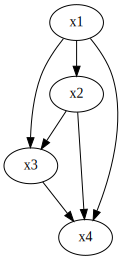

In [10]:
#Visualize the model
scm_output.cgm.draw()

In [11]:
for node in scm_output.get_topological_ordering("endogenous"):
    print(node)
for node in scm_output.get_topological_ordering("exogenous"):
    print(node)

print(scm_output.structural_equations_np['x4'])


x1
x2
x3
x4
u1
u2
u3
u4
<function sanity_3_lin_output.<locals>.<lambda> at 0x7f5a067e8cb0>


In [12]:
import importlib
from Semantic_Maningfullness import Sematic
importlib.reload(Semantic_Maningfullness)

mapping_dict={ 
      'u1': 'x1',
      'u2': 'x2',
    'u3': 'x3',
      }
results=[]
i=0
#scm_output= sanity_3_lin_output()

test_factual = test_factual.loc[:,~test_factual.columns.isin(['label'])]

for a in test_factual.index:

    if str(cfs.iloc[i]['x1'])=='nan':
        pass
    else:
        sem=Sematic(ml_model,scm_output,mapping_dict)
        
        res=sem.get_evaluation(test_factual.iloc[a],cfs.iloc[i])['semantic'][0]
        results.append( res)
    i=i+1


cflabel [[0.62281555]]
factuals_label [[0.3290373]]
threshold [[0.20093913]]
<class 'pandas.core.series.Series'>
x3    0.787217
x1   -0.125186
x2   -0.267489
Name: 0, dtype: float64
x1
[]
x2
['x1']
x3
['x1', 'x2']
x4
['x1', 'x2', 'x3']
probability [0.99930192]
cflabel [[0.9352427]]
factuals_label [[0.24872036]]
threshold [[0.55813448]]
<class 'pandas.core.series.Series'>
x3    0.971903
x1    3.335949
x2   -2.420645
Name: 1, dtype: float64
x1
[]
x2
['x1']
x3
['x1', 'x2']
x4
['x1', 'x2', 'x3']
probability [0.66588059]
cflabel [[0.5508578]]
factuals_label [[0.02519132]]
threshold [[0.53063689]]
<class 'pandas.core.series.Series'>
x3   -1.201855
x1   -0.173873
x2    1.441521
Name: 2, dtype: float64
x1
[]
x2
['x1']
x3
['x1', 'x2']
x4
['x1', 'x2', 'x3']
probability [1.]
cflabel [[0.89622825]]
factuals_label [[0.42742336]]
threshold [[0.61963095]]
<class 'pandas.core.series.Series'>
x3    0.603871
x1   -2.087104
x2    2.218720
Name: 3, dtype: float64
x1
[]
x2
['x1']
x3
['x1', 'x2']
x4
['x1', 

In [13]:
# Averaging of the reults
mean= np.mean(results)
std= np.std(results)
print(f'Semantic results {mean} +/- {std}')

Semantic results 0.8 +/- 0.4


In [14]:
#TODO This is currently not workin 
# Building Probability Distribution of the output divided into complient/ not complient
import seaborn as sns 
import matplotlib.pyplot as plt 
# Data Distribution
id_comp= np.where(np.array(results)==1)
id_not_comp=np.where(np.array(results)==0)
print(id_not_comp)
if len(id_comp[0])==0:
    cfs_complient=[]
    cfs_complient_predict=[]
    
else:
    cfs_complient=cfs.iloc[id_comp[0]]
    cfs_complient_predict=np.max(ml_model.predict(np.array(cfs_complient.values).reshape(-1,cfs_complient.values.shape[-1])),axis=1)
cfs_not_complient=cfs.iloc[id_not_comp[0]]

print(cfs_not_complient)


# cfs_not_complient_predict=np.max(ml_model.predict(np.array(cfs_not_complient).reshape(-1,7)),axis=1)


(array([4, 7]),)
         x3        x1        x2
4 -0.718443 -2.420888  4.543655
7 -0.688441 -1.589644  2.004827


In [15]:
#BoxPlot
import  numpy
from math import nan, isnan
cfs_complient_predict = [x for x in cfs_complient_predict if isnan(x) == False]
cfs_not_complient_predict = [x for x in cfs_not_complient_predict if isnan(x) == False]
cfs_complient_predict=np.array(cfs_complient_predict).reshape(-1)
cfs_not_complient_predict=np.array(cfs_not_complient_predict).reshape(-1)

print(cfs_not_complient_predict)
data = [cfs_complient_predict,cfs_not_complient_predict]

fig7, ax7 = plt.subplots()
ax7.set_title('Complient vs Not Complient')
ax7.boxplot(data)

#plt.ylim((0.99,1))
plt.show()

NameError: name 'cfs_not_complient_predict' is not defined